## Imports

In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, recall_score, make_scorer, roc_auc_score, auc, ConfusionMatrixDisplay, PrecisionRecallDisplay, precision_recall_fscore_support, precision_recall_curve, RocCurveDisplay
from sklearn.base import ClassifierMixin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from raw_data import save_all_files, concat_df
from tqdm import tqdm
import pickle

## Load the data

Loads the required datasets from google cloud. Then selects only relevant columns and saves it into /data/_year_.pkl.

In [4]:
save_all_files()

Get a coffee ;) 


100%|██████████| 5/5 [00:00<00:00, 4995.60it/s]

You already have this file's corresponding .pkl file. No need to download the .csv file again.
You already have this file's corresponding .pkl file. No need to download the .csv file again.
You already have this file's corresponding .pkl file. No need to download the .csv file again.
You already have this file's corresponding .pkl file. No need to download the .csv file again.
You already have this file's corresponding .pkl file. No need to download the .csv file again.
You successfully downloaded 0 of the 5 files.


## Concatenate data from different years to one dataframe

In [5]:
df = concat_df()
df

100%|██████████| 12/12 [00:00<00:00, 35.70it/s]


,DIABETE3,SEX,_AGEG5YR,EDUCA,_BMI5,_BMI5CAT,GENHLTH,PHYSHLTH,_TOTINDA,EXERANY2,...,SMOKDAY2,_RFSMOK3,DRNKANY5,ALCDAY5,AVEDRNK2,DRNK3GE5,_RFBING5,CVDSTRK3,CVDINFR4,CVDCRHD4
0,3.0,2.0,9.0,4.0,1855.0,2.0,4.0,88.0,2.0,2.0,...,1.0,2.0,1.0,103.0,2.0,88.0,1.0,2.0,2.0,2.0
1,3.0,1.0,3.0,3.0,3529.0,4.0,4.0,12.0,2.0,2.0,...,1.0,2.0,9.0,NaN,NaN,NaN,9.0,2.0,2.0,2.0
2,3.0,2.0,14.0,6.0,1695.0,1.0,2.0,88.0,1.0,1.0,...,3.0,1.0,1.0,101.0,1.0,88.0,1.0,2.0,2.0,2.0
3,3.0,2.0,14.0,4.0,2579.0,3.0,3.0,88.0,9.0,NaN,...,NaN,1.0,9.0,NaN,NaN,NaN,9.0,2.0,2.0,2.0
4,4.0,2.0,7.0,3.0,4346.0,4.0,5.0,25.0,1.0,1.0,...,3.0,1.0,2.0,888.0,NaN,NaN,1.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380042,1.0,2.0,11.0,2.0,1842.0,1.0,4.0,88.0,2.0,2.0,...,NaN,1.0,2.0,888.0,NaN,NaN,1.0,2.0,2.0,2.0
2380043,3.0,2.0,2.0,5.0,2834.0,3.0,1.0,88.0,1.0,1.0,...,NaN,1.0,2.0,888.0,NaN,NaN,1.0,2.0,2.0,2.0
2380044,3.0,2.0,11.0,4.0,4110.0,4.0,4.0,88.0,9.0,NaN,...,3.0,1.0,1.0,202.0,2.0,88.0,1.0,2.0,2.0,2.0
2380045,3.0,1.0,7.0,5.0,2315.0,2.0,3.0,88.0,2.0,2.0,...,NaN,1.0,2.0,888.0,NaN,NaN,1.0,2.0,2.0,2.0


## Data preparation

- [ ] feature selection
- [ ] data cleaning

In [6]:
# here the data cleaning and data preparation takes place
target_name = "DIABETE3"
feature_names = df.columns.values.tolist()
feature_names.remove(target_name)

# removed all nan values for decision tree to function
illegal_value_dict = {
    "SEX": [], 
    "_AGEG5YR": [14],
    "EDUCA": [9],
    "_BMI5": [], # nan (empty)
    "_BMI5CAT": [],
    "GENHLTH": [7, 9],
    "PHYSHLTH": [77, 88, 99],
    "_TOTINDA": [9],
    "EXERANY2": [7, 9],
    "SMOKE100": [7, 9],
    "SMOKDAY2": [7, 9],
    "_RFSMOK3": [9],
    "DRNKANY5": [7, 9],
   "ALCDAY5": [777, 999],
    "AVEDRNK2": [77, 99],
   "DRNK3GE5": [77, 99],
    "_RFBING5": [9],
    "CVDSTRK3": [7, 9],
    "CVDINFR4": [7, 9],
    "CVDCRHD4": [7, 9]
}

value_mapping = {
    "SEX": {1: 1, 2: 0}, # 1 = male, 0 = female
    # "_AGEG5YR": {},
    # "EDUCA": {}, # 1-6 ordinal categorical
    # "_BMI5": {}, # 1-999999
    # "_BMI5CAT": {}, # categorical
    # "GENHLTH": {}, # 1-5 ordinal categorical
    # "PHYSHLTH": {}, # 1-30
    "_TOTINDA": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "EXERANY2": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "SMOKE100": {1: 1, 2: 0}, # 1 = yes, 0 = no
    # "SMOKDAY2": {}, # 1 = "everyday", 2 = "some days", 3 = "not at all"
    "_RFSMOK3": {1: 0, 2: 1}, # 1 = yes, 0 = no
    "DRNKANY5": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "ALCDAY5": {888: 0, }, # categorical # TODO
    # "AVEDRNK2": {}, # 1-76 continuous
    "DRNK3GE5": {88: 0}, # 0-76 continuous
    "_RFBING5": {1: 0, 2: 1}, # 1 = yes, 0 = no
    "CVDSTRK3": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "CVDINFR4": {1: 1, 2: 0}, # 1 = yes, 0 = no
    "CVDCRHD4": {1: 1, 2: 0} # 1 = yes, 0 = no
 }

feature_list = [
    "SEX", 
    "_AGEG5YR",
    "EDUCA", 
    "_BMI5", 
    "_BMI5CAT",
    "GENHLTH", 
    "PHYSHLTH",
    "_TOTINDA", 
    "EXERANY2", 
    "SMOKE100", 
    "SMOKDAY2", 
    "_RFSMOK3", 
    "DRNKANY5", 
    "ALCDAY5", 
    "AVEDRNK2", 
    "DRNK3GE5", 
    "_RFBING5", 
    "CVDSTRK3", 
    "CVDINFR4", 
    "CVDCRHD4"
]

renames = [
    "sex",
    "age",
   "education",
    "body_mass_index",
    "bmi_cat",
    "estimated_health",
    "bad_physhealth_days",
    "had_phys_activity",
    "any_exercise",
    "smoked_over_100",
    "smokes_daily",
    "is_smoker",
    "alcohol_past_30",
    "one_drink_per_day_month_last_30",
    "average_drinks",
    "more_than_5_drinks",
    "more_than_5_drinks_on_one_occasion",
    "had_stroke",
    "had_heart_attack",
    "had_angina"
]

# only include rows with diabetes = yes and no and select relevant columns
df_filtered = df.loc[df["DIABETE3"].isin([1, 3]), feature_list + [target_name]]

# filter out illegal values for each feature
for column, bad_value_list in tqdm(illegal_value_dict.items()):
    df_filtered = df_filtered[~df_filtered[column].isin(bad_value_list)]

# map values for each feature
for column, mapping in tqdm(value_mapping.items()):
    df_filtered[column] = df_filtered[column].map(mapping)

# rename label 1 = 1 = yes (has diabetes) | 3 = 0 = no (no diabetes)
df_filtered["DIABETE3"] = df_filtered["DIABETE3"].map({1: 1, 3: 0})
df_filtered.columns = renames + [target_name]
df_filtered

100%|██████████| 12/12 [00:00<00:00, 25.62it/s]


,sex,age,education,body_mass_index,bmi_cat,estimated_health,bad_physhealth_days,had_phys_activity,any_exercise,smoked_over_100,...,is_smoker,alcohol_past_30,one_drink_per_day_month_last_30,average_drinks,more_than_5_drinks,more_than_5_drinks_on_one_occasion,had_stroke,had_heart_attack,had_angina,DIABETE3
31,1,8.0,6.0,2585.0,3.0,2.0,2.0,1,1,1,...,0,1,NaN,2.0,0.0,0,0,0.0,0,0
35,0,5.0,5.0,2391.0,2.0,4.0,5.0,0,0,0,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
36,0,5.0,5.0,3411.0,4.0,4.0,15.0,0,0,1,...,0,0,0.0,NaN,NaN,0,0,0.0,0,1
37,0,9.0,4.0,2575.0,3.0,4.0,20.0,0,0,1,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
39,0,11.0,5.0,2146.0,2.0,3.0,2.0,1,1,0,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380029,0,1.0,5.0,1785.0,1.0,3.0,4.0,1,1,0,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
2380032,1,9.0,4.0,3119.0,4.0,4.0,30.0,0,0,0,...,0,0,0.0,NaN,NaN,0,0,0.0,0,0
2380035,1,1.0,4.0,NaN,NaN,1.0,2.0,1,1,0,...,0,1,NaN,2.0,0.0,0,0,0.0,0,0
2380039,1,3.0,6.0,4229.0,4.0,3.0,4.0,1,1,0,...,0,1,NaN,2.0,0.0,0,0,0.0,0,0


In [7]:
# selected_features = [
#     "age",
#     "body_mass_index",
#     "estimated_health",
#     "bad_physhealth_days",
#     "had_phys_activity",
#     "is_smoker",
# ]

feature_list = [feature for feature in renames if feature not in ['more_than_5_drinks','average_drinks', 'smokes_daily','one_drink_per_day_month_last_30', 'bmi_cat', 'education']]

df_filtered = df_filtered.loc[:, feature_list + [target_name]]

df_filtered

,sex,age,body_mass_index,estimated_health,bad_physhealth_days,had_phys_activity,any_exercise,smoked_over_100,is_smoker,alcohol_past_30,more_than_5_drinks_on_one_occasion,had_stroke,had_heart_attack,had_angina,DIABETE3
31,1,8.0,2585.0,2.0,2.0,1,1,1,0,1,0,0,0.0,0,0
35,0,5.0,2391.0,4.0,5.0,0,0,0,0,0,0,0,0.0,0,0
36,0,5.0,3411.0,4.0,15.0,0,0,1,0,0,0,0,0.0,0,1
37,0,9.0,2575.0,4.0,20.0,0,0,1,0,0,0,0,0.0,0,0
39,0,11.0,2146.0,3.0,2.0,1,1,0,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380029,0,1.0,1785.0,3.0,4.0,1,1,0,0,0,0,0,0.0,0,0
2380032,1,9.0,3119.0,4.0,30.0,0,0,0,0,0,0,0,0.0,0,0
2380035,1,1.0,NaN,1.0,2.0,1,1,0,0,1,0,0,0.0,0,0
2380039,1,3.0,4229.0,3.0,4.0,1,1,0,0,1,0,0,0.0,0,0


### Drop missing and bad input values

In [8]:
nan_amounts = [df_filtered[col].isnull().values.sum() for col in df_filtered.columns]
cols_with_nan_amounts = list(zip(df_filtered.columns, nan_amounts))
cols_with_nan_amounts.sort(key=lambda x: x[1], reverse=True)
cols_with_nan_amounts

[('body_mass_index', 31915),
 ('estimated_health', 11),
 ('bad_physhealth_days', 3),
 ('had_heart_attack', 1),
 ('sex', 0),
 ('age', 0),
 ('had_phys_activity', 0),
 ('any_exercise', 0),
 ('smoked_over_100', 0),
 ('is_smoker', 0),
 ('alcohol_past_30', 0),
 ('more_than_5_drinks_on_one_occasion', 0),
 ('had_stroke', 0),
 ('had_angina', 0),
 ('DIABETE3', 0)]

In [9]:
# drop na drops [NAN] of the rows...
df_prepared = df_filtered.dropna().reset_index(drop=True)

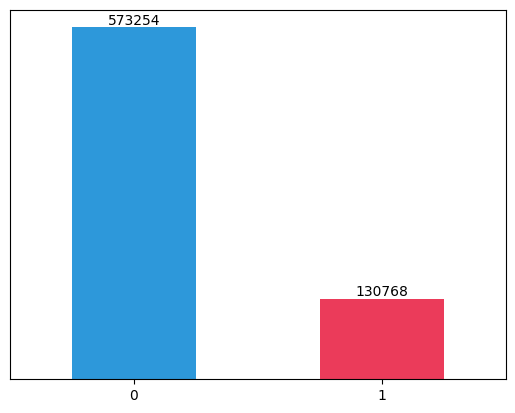

In [10]:
# viz unbalanced data
fontsize = 10
viz1 = df_prepared.DIABETE3.value_counts().plot(kind= "bar", rot = 0, color = ["#2d98da", "#eb3b5a"], fontsize = fontsize)
viz1.bar_label(viz1.containers[0], fontsize= fontsize)
# plt.xlabel("Diabetes", fontsize=fontsize)
# plt.ylabel("Count", fontsize= fontsize)
# plt.title("Imbalanced Data: #Records ", fontsize = fontsize)

viz1.get_yaxis().set_visible(False)

## the model will learn to classify "no Diabetes" better as there are more records in this class. Imbalanced data has consequences for further approach!!


In [11]:
df_prepared.describe()

,sex,age,body_mass_index,estimated_health,bad_physhealth_days,had_phys_activity,any_exercise,smoked_over_100,is_smoker,alcohol_past_30,more_than_5_drinks_on_one_occasion,had_stroke,had_heart_attack,had_angina,DIABETE3
count,704022.000000,704022.000000,704022.000000,704022.000000,704022.000000,704022.000000,704022.000000,704022.000000,704022.000000,704022.000000,704022.000000,704022.000000,704022.000000,704022.000000,704022.000000
mean,0.381809,7.777329,2874.101978,3.111225,11.616451,0.670436,0.670436,0.493631,0.189193,0.454807,0.117508,0.064651,0.089169,0.097230,0.185744
std,0.485830,3.336662,695.445819,1.148362,11.121202,0.470055,0.470055,0.499960,0.391662,0.497954,0.322025,0.245910,0.284988,0.296271,0.388900
min,0.000000,1.000000,1201.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,2403.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,8.000000,2746.000000,3.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,10.000000,3210.000000,4.000000,20.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,13.000000,9920.000000,5.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Model training
- [ ] model selection
- [ ] train-test split (maybe before data prep)
- [ ] hyperparameter tuning
- [ ] more stuff

In [116]:
# defining threshold - any prediction with a probability greater than this threshold will be labelled as "has diabetes"
threshold = 0.2

In [117]:
# function plotting all relevant graphs for each model
# ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

def analyse_model(model: ClassifierMixin, X_test: pd.DataFrame, y_test: pd.Series, axes=None):

    # binary labels predicted by model
    y_predict = (model.predict_proba(X_test)[:,1] >= threshold).astype(int)

    # probability of having diabetes predicted by model
    y_proba = model.predict_proba(X_test)[:, 1]

    precision, recall, _, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_predict)

    # print recall for 1 = has diabetes
    print(f"Precision for 'has diabetes' = {round(precision[1] * 100, 2)} %")
    print(f"Recall for 'has diabetes' = {round(recall[1] * 100, 2)} %")

    # display Confusionmatrix
    cfm = ConfusionMatrixDisplay.from_predictions(y_test, y_predict, display_labels=model.classes_)
    
    # display precision_recall_curve
    prd = PrecisionRecallDisplay.from_predictions(y_test, y_proba) # add drawstyle="default" to make the curve smoother - but less accurate
    # print(precision_recall_curve(y_test, y_proba)[2])

    # display Roc Curve
    rcd = RocCurveDisplay.from_predictions(y_true=y_test, y_pred=y_predict)

    return precision_recall_curve(y_test, y_proba)

    

In [118]:
# drying up the code (DRY - dont repeat yourself)

# todo: add param_list
def evaluate_model(df: pd.DataFrame, features: list, target: str, classifier: ClassifierMixin, params={}):
    
    # TODO: create custom scorer to use recall instead of accuracy score in model training
    # my_recall_scorer = make_scorer(recall_score)

    # print("Function was called")

    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=41)
    
    # print("Finished test train split")

    model = classifier(**params, random_state=42)

    # print("Model was defined")

    # print("Fitting Model ...")
    model.fit(X_train, y_train)
    # print("Model fitted successfully")

    return analyse_model(model, X_test, y_test)

    # return model
    # model = ExtraTreesClassifier(random_state=42)
    # CV_model = RandomizedSearchCV(estimator=model, param_distributions=param_grid_hist, cv=4, n_jobs=2, scoring=my_recall_scorer, verbose=5)

In [119]:
# drying up the code (DRY - dont repeat yourself)

# todo: add param_list
def get_best_model(df: pd.DataFrame, features: list, target: str, classifier: ClassifierMixin, param_distribution={}):
    
    # TODO: create custom scorer to use recall instead of accuracy score in model training
    # my_recall_scorer = make_scorer(recall_score)

    # print("Function was called")

    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=41)
    
    # print("Finished test train split")

    model = classifier(**param_distribution, random_state=42)
    # model = ExtraTreesClassifier(random_state=42)
    CV_model = RandomizedSearchCV(estimator=model, param_distributions=param_grid_hist, cv=4, n_jobs=2, scoring=my_recall_scorer, verbose=5)

    # print("Model was defined")

    # print("Fitting Model ...")
    model.fit(X_train, y_train)
    # print("Model fitted successfully")

    analyse_model(model, X_test, y_test)

    return model
    # model = ExtraTreesClassifier(random_state=42)
    # CV_model = RandomizedSearchCV(estimator=model, param_distributions=param_grid_hist, cv=4, n_jobs=2, scoring=my_recall_scorer, verbose=5)

## Analysing Decision Tree

[0 0 0 1 0]
[0.15315311 0.07838282 0.0054182  0.42278265 0.01290349]
Precision for 'has diabetes' = 37.25 %
Recall for 'has diabetes' = 75.41 %


56.33

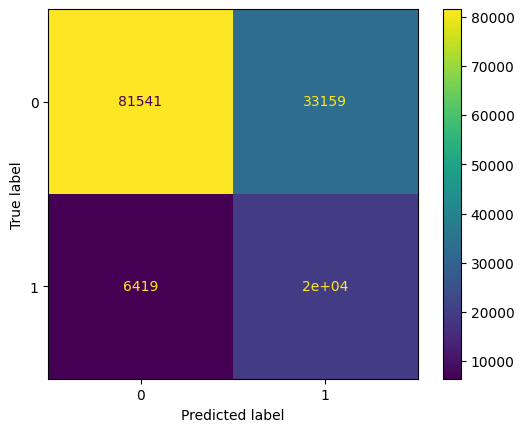

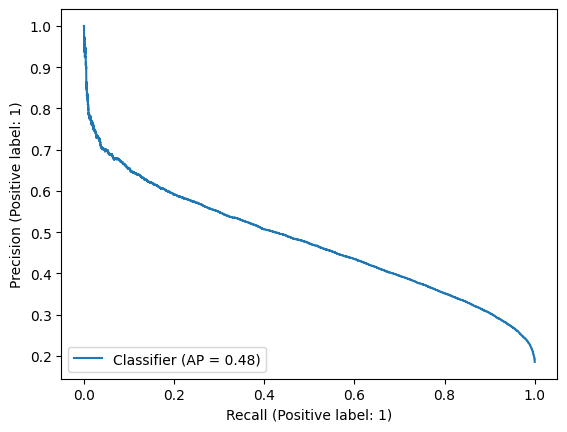

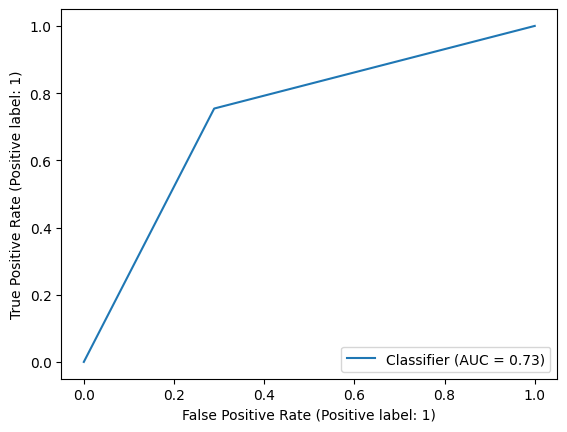

In [121]:
model = evaluate_model(df_prepared, feature_list, target_name, HistGradientBoostingClassifier)
# model2 = evaluate_model(df_prepared, feature_list, target_name, DecisionTreeClassifier)
# model3 = evaluate_model(df_prepared, feature_list, target_name, RandomForestClassifier)

# model = evaluate_model(features=feature_list, df=df_prepared,  target=target_name, classifier=HistGradientBoostingClassifier)

In [115]:
prec, rec, thresholds = model
combinations = list(zip(prec, rec, thresholds))
# combinations
with open("test.txt", "w") as f:
    f.write(str(combinations))

In [16]:
# used for GridSearchCV
param_grid = { 
    'n_estimators': [200, 500], # 500
    'max_features': ['sqrt', 'log2'], # 'auto' 
    'max_depth' : [4, 8], # 7,8
    'criterion' :['gini', 'entropy']
} # best for rfc RandomForestClassifier(max_depth=6, max_features='auto', n_estimators=300, random_state=42)

# used for GridSearchCV / DecisionTreeClassifier
param_grid_dtc = {
    'max_features': ['sqrt', 'log2'], # 'auto'
    'max_depth' : [4, 15], # 7,8
    'criterion' :['gini', 'entropy']
} # best for

# used for GridSearchCV / ExtraTreesClassifier
param_grid_etc = {
    'n_estimators': np.arange(100, 500, 10), # 500
    'max_features': ['sqrt', 'log2'], # 'auto'
    'max_depth': np.arange(6, 32, 1),
    'criterion' :['gini', 'entropy']
}

# used for GridSearchCV / ExtraTreesClassifier
param_grid_hist = {
    'loss': ['log_loss'], # 500
    'learning_rate': np.arange(0.01, 0.5, 0.02),
    'max_iter': np.arange(100, 400, 100),
    'max_leaf_nodes': np.arange(3, 40, 2),
}

# used for RandomizedSearchCV
param_distributions = { 
    'n_estimators': np.arange(100, 500, 10), # 500
    'max_features': ['sqrt', 'log2'], # 'auto' 
    'max_depth' : np.arange(4, 15), # 7,8
    'criterion' :['gini', 'entropy']
} # best for RandomForestClassifier(max_depth=7, max_features='log2', n_estimators=220, random_state=42)

my_recall_scorer = make_scorer(recall_score)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_prepared[feature_list], df_prepared[target_name], test_size=0.2, random_state=41)

model = HistGradientBoostingClassifier(random_state=42)
# model = ExtraTreesClassifier(random_state=42)
CV_model = RandomizedSearchCV(estimator=model, param_distributions=param_grid_hist, cv=4, n_jobs=2, scoring=my_recall_scorer, verbose=5)

### ATTENTION this takes up to 70 Minutes

In [18]:
CV_model.fit(X_train, y_train)
model = CV_model.best_estimator_
CV_model.best_score_

Fitting 4 folds for each of 10 candidates, totalling 40 fits


KeyboardInterrupt: 

In [ ]:
filename = "ExtraTreesClassifier.sav"
loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
best_params = loaded_model.get_params()

X_train, X_test, y_train, y_test = train_test_split(df_prepared[feature_list], df_prepared[target_name], test_size=0.2, random_state=41)

best_model = ExtraTreesClassifier(**best_params)
best_model.fit(X_train, y_train)

In [ ]:
model = best_model
y_predict = model.predict(X_test)

y_score = model.predict_proba(X_test)[:, 1]
# y_score = CV_model.decision_function(X_test)

matrix = confusion_matrix(y_test, y_predict, labels = [1,0])
print(matrix)

precision, recall, _, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_predict, labels= [1,0])
roc_auc_scores = roc_auc_score(y_true=y_test, y_score=y_score, labels= [1,0])

print(f"Precision for 'yes' = {precision[0]}")
print(f"Precision for 'no' = {precision[1]}")
print(f"recall for 'yes' = {recall[0]}")
print(f"recall for 'no' = {recall[1]}")
print(f"roc_auc_score = {roc_auc_scores}")

### Confusion Matrix

In [ ]:
matrix = confusion_matrix(y_test, y_predict, labels = model.classes_)
matrix_display = ConfusionMatrixDisplay(matrix, display_labels = model.classes_).plot()

# sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')

### Predict Probabilities instead of classes
Precision-Recall Curves for imbalanced datasets
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [ ]:
y_predict_proba = model.predict_proba(X_test)[:, 1]

### Precision-Recall-Curve

In [ ]:
p_precision, p_recall, _ = precision_recall_curve(y_test, y_predict_proba)
p_precision, p_recall


In [ ]:
#viz
fig, ax = plt.subplots()
ax.plot(p_recall, p_precision, color="blue")
ax.set_title("Precision-Recall Curve")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")


In [ ]:
baseline_model = sum(y_test) / len(y_test)
plt.plot([0, 1], [baseline_model, baseline_model], linestyle='--', label='baseline model')

plt.plot(p_recall, p_precision, marker = ".", label = "ExtraTreesClassifier")
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [ ]:
# precision recall curve shows:
# -tradeoff between the false positives and false negatives. As we want to achieve the smallest number of false negatives possible,
# we can accept a higher number of false positives (and a lower precision) in return. 

### Roc Curve

In [ ]:
roc_auc_scores = roc_auc_score(y_test, y_predict_proba, labels = model.classes_)
roc_auc_scores

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_predict_proba)

In [ ]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="Precision and Recall for Classifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

### Save model

In [ ]:
filename = "ExtraTreesClassifier.sav"
pickle.dump(model, open(filename, 'wb'))

### Load model

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
print(loaded_model.get_params())

In [ ]:
score = recall_score(y_test, y_predict)
print(score)

In [ ]:
test = model.feature_importances_
z= list(zip(feature_list, test))
z.sort(key=lambda x: x[1], reverse=True)
z

## Use Model to predict user's diabetes probability

### Get user input

In [ ]:
# please input data: ...

# use data for diabetes proba
user_row = df_prepared.loc[[11], feature_list].reset_index(drop=True) # got a random index just as an example
probas = model.predict_proba(user_row)
print(user_row)
# label_meanings = (
#     "diabetes",
#     "diabetes during pregnancy",
#     "pre-diabetes or borderline diabetes",
#     "don't know",
#     "refused",
#     "BLANK"
# )
probas
# for l, p in probas.tolist():
#     print(f"With a probability of {round(p*100, 2)}% you (will) have result: {l}.")

### Make recommendations: What factors have the most significant impact on the user's diabetes probability?